# Accelerated Alternating Projection

Paper: https://arxiv.org/pdf/1711.05519.pdf

Matlab Script: https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/AccAltProj.m

Full Repository: https://github.com/caesarcai/AccAltProj_for_RPCA 

In [1]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math

from helper import *

torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
hello()

hello!


In [3]:
np.random.seed(0)
torch.manual_seed(0)

## ======================== Parameters ========================
d1 = 50                   # num. of rows
d2 = 50                   # num. of columns
max_iter = 40              # num. of layers trained
r = 2
alpha = 0.05

## Classical

In [4]:
## generate data
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha, c=10)

In [5]:
## start with M_true, assuming known rank
## error tolerance = 1e-6, gamma = 0.5, max_iter = 100
loss, L_hat, S_hat = AccAltProj(M_true, r, 1e-6, torch.tensor(0.7), max_iter)

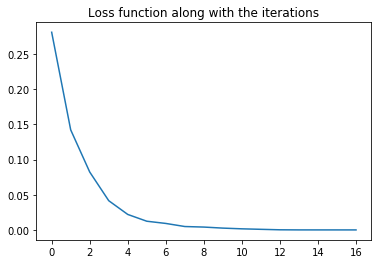

tensor(8.850e-07)
tensor(1.456e-06)
tensor(1.398e-06)


In [6]:
plt.plot(loss)
plt.title('Loss function along with the iterations')
plt.show()

print(loss[-1])
print(torch.linalg.norm(L_hat - L_true)/ torch.linalg.norm(L_true))
print(torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))

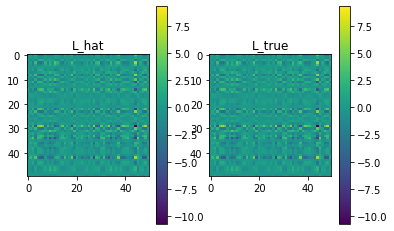

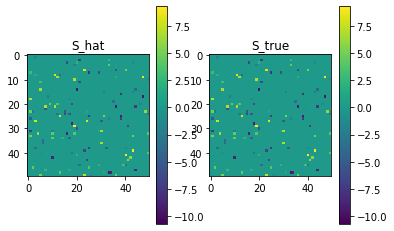

In [7]:
plot_true_vs_est_matrices(L_hat, L_true, S_hat, S_true)

## Unrolled version

In [113]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = thres(M0, zeta, hard=False)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = thres(S, zeta, hard=False)
        return S, L, U, V, beta, norm_of_M0

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay
    def forward(self, M0, S, U, V, r, beta):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sm[r] + torch.pow(self.gamma, self.lay) * Sm[0])
        S = M0 - L
        S = thres(S, zeta, hard=False)
        return S, L, U, V

class LearnedAAP(nn.Module):
    def __init__(self, max_iter):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))
        #self.gamma = torch.tensor(0.7)
        self.beta = nn.Parameter(torch.tensor(0.03))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            #self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
            #self.layer.append(ProjStage(gamma = nn.Parameter(self.gamma.clone().detach().requires_grad_(True))))
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.loss = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, beta, norm_of_M0 = lay_init(M0, r)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V = lay(M0, S, U, V, r, self.beta)
            self.loss[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

## The Pipeline

In [163]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
alpha_true = 0.1
c_true = 1
r = 2
dataset_size = 1000

## ======================== 1. generate data ========================
train, test =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 900
test dataset size: 100


In [164]:
## ======================== 2. estimations by classical ========================
train_est = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    train_est.append((L0, S0, M_true))

## get metrics comparing (L0, M0 with L_true, S_true)

In [165]:
## ======================== 3. train unrolled network with estimated data ========================
net = LearnedAAP(max_iter)
params_bftrain = [x.clone().detach().numpy() for x in list(net.parameters())]

optimizer=Adam(net.parameters(), lr=2e-04, weight_decay=1e-06)

nepochs = 100
l0_norm_of_S_Shat = []

for epoch in range(nepochs):
    for i in range(len(train_est)// nepochs):
        L0, S0, M0 = train_est[i]
        optimizer.zero_grad()
        L_hat, S_hat = net(M0, r)
        loss = torch.pow(torch.linalg.norm(L0 - L_hat), 2) \
                + torch.pow(torch.linalg.norm(S0 - S_hat), 2) \
                + torch.pow(torch.linalg.norm(M0 - L_hat - S_hat), 2)
        loss.backward()
        optimizer.step()
        l0_norm_of_S_Shat.append(torch.count_nonzero(S0 - S_hat))
    print(list(net.parameters()))
    print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(loss.item()))

print('Finished Training')

[Parameter containing:
tensor(6.982e-01, requires_grad=True), Parameter containing:
tensor(2.823e-02, requires_grad=True)]
Epoch 1/100 at cost=2.897312469940516e-07
[Parameter containing:
tensor(6.966e-01, requires_grad=True), Parameter containing:
tensor(2.656e-02, requires_grad=True)]
Epoch 2/100 at cost=2.403947405582585e-07
[Parameter containing:
tensor(6.951e-01, requires_grad=True), Parameter containing:
tensor(2.502e-02, requires_grad=True)]
Epoch 3/100 at cost=1.9212504298593558e-07
[Parameter containing:
tensor(6.938e-01, requires_grad=True), Parameter containing:
tensor(2.363e-02, requires_grad=True)]
Epoch 4/100 at cost=2.019501152972225e-07
[Parameter containing:
tensor(6.927e-01, requires_grad=True), Parameter containing:
tensor(2.239e-02, requires_grad=True)]
Epoch 5/100 at cost=1.4406980142211978e-07
[Parameter containing:
tensor(6.917e-01, requires_grad=True), Parameter containing:
tensor(2.129e-02, requires_grad=True)]
Epoch 6/100 at cost=1.299105747420981e-07
[Paramet

### Evaluating unrolled network on train dataset

In [172]:
out_bftrain, out_hat = get_net_outputs(net, LearnedAAP(max_iter), r, train)

In [180]:
fro_norm_L_old = []
mse_S_old = []
fro_norm_S_old = []
count_nonzeros_S_old = []
relative_err_old = []

fro_norm_L_new = []
mse_S_new = []
fro_norm_S_new = []
count_nonzeros_S_new = []
relative_err_new = []

fro_norm_L_bftrain = []
mse_S_bftrain = []
fro_norm_S_bftrain = []
count_nonzeros_S_bftrain = []
relative_err_bftrain = []

mse = nn.MSELoss()

for i, (L_true, S_true, M_true) in enumerate(train):
    # between true and classical/ est
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), 40)
    fro_norm_L_old.append(torch.linalg.norm(L_true - L0).detach().numpy())
    mse_S_old.append(mse(S_true, S0).detach().numpy())
    fro_norm_S_old.append(torch.linalg.norm(S_true - S0).detach().numpy())
    count_nonzeros_S_old.append(torch.count_nonzero(S_true - S0).detach().numpy())
    relative_err_old.append((torch.linalg.norm(M_true - L0 - S0)/ torch.linalg.norm(M_true)).detach().numpy())
    # between true and hat
    L_hat, S_hat = out_hat[i]
    fro_norm_L_new.append(torch.linalg.norm(L_true - L_hat).detach().numpy())
    mse_S_new.append(mse(S_true, torch.tensor(S_hat)).detach().numpy())
    fro_norm_S_new.append(torch.linalg.norm(S_true - S_hat).detach().numpy())
    count_nonzeros_S_new.append(torch.count_nonzero(S_true - S_hat).detach().numpy())
    relative_err_new.append((torch.linalg.norm(M_true - L_hat - S_hat)/ torch.linalg.norm(M_true)).detach().numpy())
    # between true and bftrain
    L_bftrain, S_bftrain = out_bftrain[i]
    fro_norm_L_bftrain.append(torch.linalg.norm(L_true - L_bftrain).detach().numpy())
    mse_S_bftrain.append(mse(S_true, torch.tensor(S_bftrain)).detach().numpy())
    fro_norm_S_bftrain.append(torch.linalg.norm(S_true - S_bftrain).detach().numpy())
    count_nonzeros_S_bftrain.append(torch.count_nonzero(S_true - S_bftrain).detach().numpy())
    relative_err_bftrain.append((torch.linalg.norm(M_true - L_bftrain - S_bftrain)/ torch.linalg.norm(M_true)).detach().numpy())

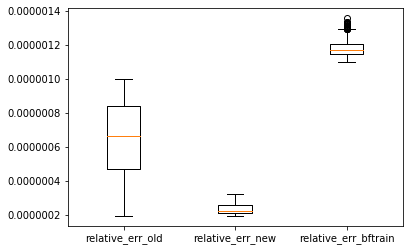

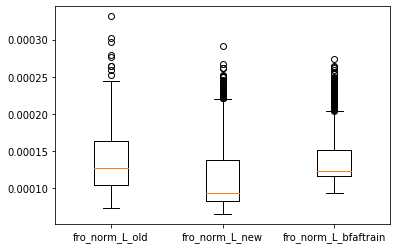

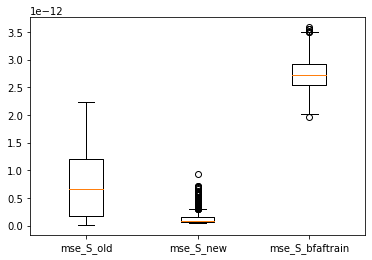

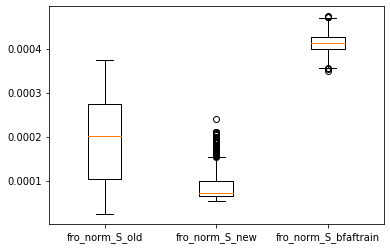

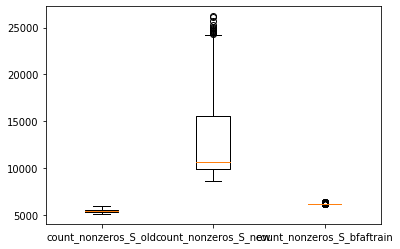

In [181]:
fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain])
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain])
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain])
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain])
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain])
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain"])
plt.show()

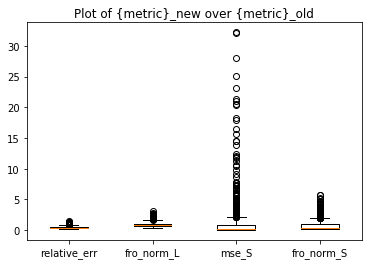

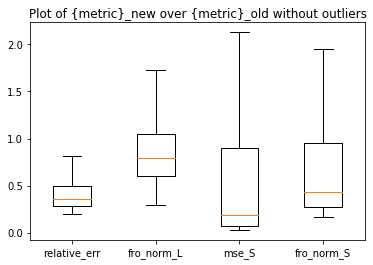

relative_err: 44/900 outliers
fro_norm_L: 63/900 outliers
mse_S: 121/900 outliers
fro_norm_S: 67/900 outliers


In [183]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    #, "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

### Evaluating unrolled network on test dataset

In [184]:
out_bftrain_ontest, out_hat_ontest = get_net_outputs(net, LearnedAAP(max_iter), r, test)

In [185]:
fro_norm_L_old = []
mse_S_old = []
fro_norm_S_old = []
count_nonzeros_S_old = []
relative_err_old = []

fro_norm_L_new = []
mse_S_new = []
fro_norm_S_new = []
count_nonzeros_S_new = []
relative_err_new = []

fro_norm_L_bftrain = []
mse_S_bftrain = []
fro_norm_S_bftrain = []
count_nonzeros_S_bftrain = []
relative_err_bftrain = []

mse = nn.MSELoss()

for i, (L_true, S_true, M_true) in enumerate(test):
    # between true and classical/ est
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), 40)
    fro_norm_L_old.append(torch.linalg.norm(L_true - L0).detach().numpy())
    mse_S_old.append(mse(S_true, S0).detach().numpy())
    fro_norm_S_old.append(torch.linalg.norm(S_true - S0).detach().numpy())
    count_nonzeros_S_old.append(torch.count_nonzero(S_true - S0).detach().numpy())
    relative_err_old.append((torch.linalg.norm(M_true - L0 - S0)/ torch.linalg.norm(M_true)).detach().numpy())
    # between true and hat
    L_hat, S_hat = out_hat_ontest[i]
    fro_norm_L_new.append(torch.linalg.norm(L_true - L_hat).detach().numpy())
    mse_S_new.append(mse(S_true, torch.tensor(S_hat)).detach().numpy())
    fro_norm_S_new.append(torch.linalg.norm(S_true - S_hat).detach().numpy())
    count_nonzeros_S_new.append(torch.count_nonzero(S_true - S_hat).detach().numpy())
    relative_err_new.append((torch.linalg.norm(M_true - L_hat - S_hat)/ torch.linalg.norm(M_true)).detach().numpy())
    # between true and bftrain
    L_bftrain, S_bftrain = out_bftrain_ontest[i]
    fro_norm_L_bftrain.append(torch.linalg.norm(L_true - L_bftrain).detach().numpy())
    mse_S_bftrain.append(mse(S_true, torch.tensor(S_bftrain)).detach().numpy())
    fro_norm_S_bftrain.append(torch.linalg.norm(S_true - S_bftrain).detach().numpy())
    count_nonzeros_S_bftrain.append(torch.count_nonzero(S_true - S_bftrain).detach().numpy())
    relative_err_bftrain.append((torch.linalg.norm(M_true - L_bftrain - S_bftrain)/ torch.linalg.norm(M_true)).detach().numpy())

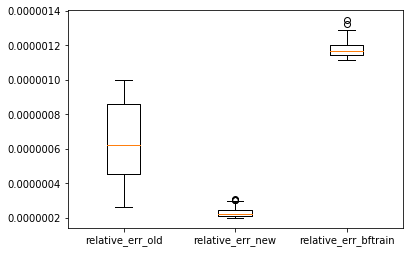

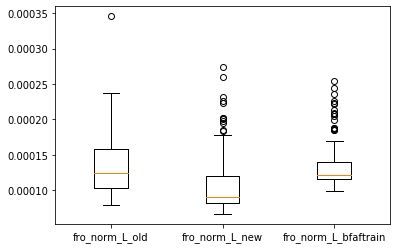

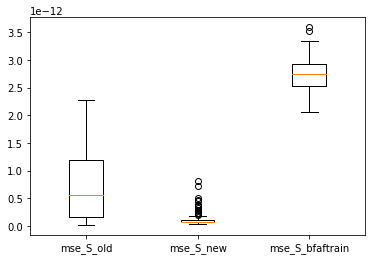

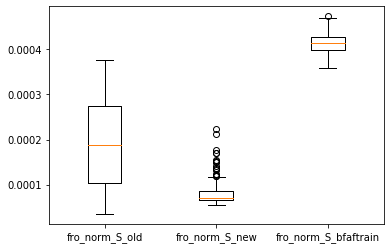

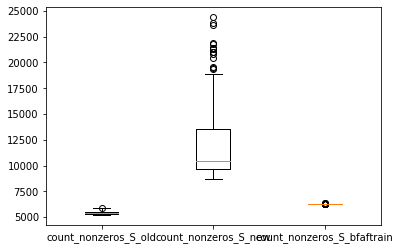

In [186]:
fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain])
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain])
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain])
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain])
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain])
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain"])
plt.show()

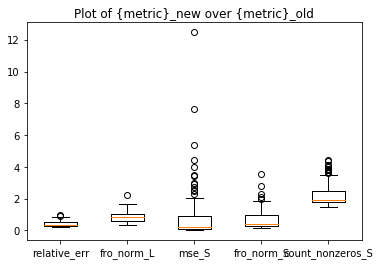

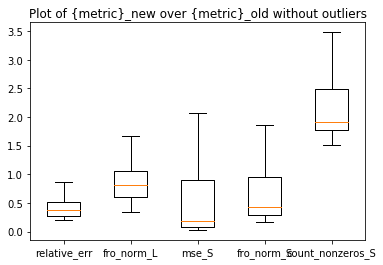

relative_err: 2/100 outliers
fro_norm_L: 1/100 outliers
mse_S: 13/100 outliers
fro_norm_S: 5/100 outliers
count_nonzeros_S: 14/100 outliers


In [187]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")